# Sentiment Analysis on Bitcoin Related Tweets
1. dataset source: https://data.world/mercal/btc-tweets-sentiment/workspace
2. This is a tagged dataset with 3 sentiment category: positive, neutral, and negative

### Question we would like to answer
How the public think about crypto currencies, bitcoin in particular, based on sentiment analysis？ How the sentiment varies among different countries and regions? 

#### Structure of this Notebook: 
- Data Pre-processing for Sentiment Analysis
- Visualization of Frequent Words
- Create Features
- Oversampling the Dataset
- Model Selection and Tuning
- References

In [67]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [45]:
#read data and show the top five rows 
tagged_tweets=pd.read_csv("BTC_tweets_daily_example.csv")
tagged_tweets.head()

,Unnamed: 0,Date,Tweet,Screen_name,Source,Link,Sentiment,sent_score,New_Sentiment_Score,New_Sentiment_State
0,0,Fri Mar 23 00:40:32 +0000 2018,"RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I h...",myresumerocket,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['neutral'],0.0,0.000000,0.0
1,1,Fri Mar 23 00:40:34 +0000 2018,@lopp @_Kevin_Pham @psycho_sage @naval But @Pr...,BitMocro,[u'Bitcoin'],"<a href=""http://twitter.com/download/android"" ...",['neutral'],0.0,0.000000,0.0
2,2,Fri Mar 23 00:40:35 +0000 2018,RT @tippereconomy: Another use case for #block...,hojachotopur,"[u'blockchain', u'Tipper', u'TipperEconomy']","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive'],1.0,0.136364,1.0
3,3,Fri Mar 23 00:40:36 +0000 2018,free coins https://t.co/DiuoePJdap,denies_distro,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive'],1.0,0.400000,1.0
4,4,Fri Mar 23 00:40:36 +0000 2018,RT @payvxofficial: WE are happy to announce th...,aditzgraha,[],"<a href=""http://twitter.com/download/android"" ...",['positive'],1.0,0.468182,1.0


In [46]:
#only keep rows that we need 
cleaned=tagged_tweets[['Unnamed: 0','Date','Tweet','Sentiment','sent_score']]
#drop nan values 
cleaned=cleaned.dropna()
#reset index
cleaned=cleaned.reset_index(drop=True)
cleaned.head()

,Unnamed: 0,Date,Tweet,Sentiment,sent_score
0,0,Fri Mar 23 00:40:32 +0000 2018,"RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I h...",['neutral'],0.0
1,1,Fri Mar 23 00:40:34 +0000 2018,@lopp @_Kevin_Pham @psycho_sage @naval But @Pr...,['neutral'],0.0
2,2,Fri Mar 23 00:40:35 +0000 2018,RT @tippereconomy: Another use case for #block...,['positive'],1.0
3,3,Fri Mar 23 00:40:36 +0000 2018,free coins https://t.co/DiuoePJdap,['positive'],1.0
4,4,Fri Mar 23 00:40:36 +0000 2018,RT @payvxofficial: WE are happy to announce th...,['positive'],1.0


<AxesSubplot:xlabel='sent_score', ylabel='Count'>

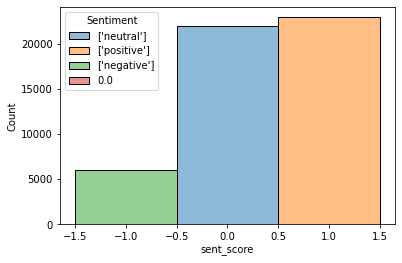

In [47]:
import seaborn as sns
%matplotlib inline

# show distribution (count) for each sentiment category
sns.histplot(data=cleaned, x="sent_score",hue="Sentiment",discrete=True)

#observed an unbalanced sentiment distribution 

## Data Pre-processing for Sentiment Analysis 
1. remove hashtags and mentions 
2. remove links 
3. remove punctuations 
4. filter all non-alphanumeric characters including emoticons and emojis 
5. tokenize all tweets 
6. remove stop words  -- update stop words first

In [48]:
!pip install nltk

In [68]:
# You might need to uncomment the code below to install the two below package
#nltk.download('stopwords')
#nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/zhangyi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [49]:
#import nltk and regular expression modules to help process text data
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


#get all tweets 
all_tweets=cleaned[['Tweet']].values.tolist()
cleaned_tweets_tokens=[]
cleaned_tweets=[]

#update stop words list with the common word bitcoin 
stop_words = set(stopwords.words('english'))
stop_words.update(['bitcoin'])

#data cleaning
for each in all_tweets:
    temp = each[0].lower()
    #remove hashtags and mentions 
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    #remove links
    temp = re.sub(r"http\S+", "", temp)
    temp = re.sub(r"www.\S+", "", temp)
    #remove punctuations
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    #filter all non-alphanumeric characters (emoticons emoji)
    temp = re.sub("[^a-z0-9]"," ", temp)
    #tokenize
    word_tokens = word_tokenize(temp)
    filtered= [w for w in word_tokens if not w in stop_words]
    filtered_join=' '.join(filtered)
    #create two different list, one for tokenized tweets, one for strings 
    cleaned_tweets.append(filtered_join)
    cleaned_tweets_tokens.append(filtered)

<AxesSubplot:xlabel='word_count', ylabel='Count'>

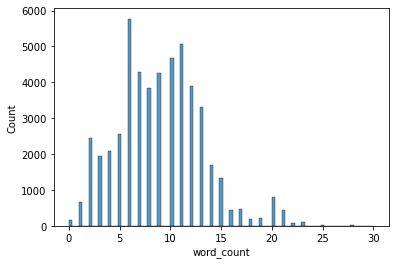

In [50]:
# add one more column to the cleaned dataframe: word_count
word_count=[]
for each in cleaned_tweets_tokens:
    word_count.append(len(each))
cleaned['word_count']=word_count

#visualize the distribution of tweet word count
sns.histplot(data=cleaned, x="word_count")

## Visualization of Frequent Words 

In [51]:
from nltk.tag import pos_tag
from nltk import FreqDist

#define a function to get all tokens from the token list 
def get_all_words(tokens_list):
    for tokens in tokens_list:
        for token in tokens:
            yield token

#get index for positive, neutral, negative comments based on the cleanded dataframe          
positive_index=cleaned.index[cleaned['sent_score'] == 1.0].tolist()
neutral_index=cleaned.index[cleaned['sent_score'] == 0].tolist()
negative_index=cleaned.index[cleaned['sent_score'] == -1].tolist()

# get token lists for positive, neutral, and negative comments 
positive_tweets_tokens= [cleaned_tweets_tokens[i] for i in positive_index]
neutral_tweets_tokens= [cleaned_tweets_tokens[i] for i in neutral_index]
negative_tweets_tokens= [cleaned_tweets_tokens[i] for i in negative_index]

In [52]:
#A frequency distribution records the number of times each outcome of an experiment has occurred
#get frequency distribution for each sentiment category
all_pos_words = get_all_words(positive_tweets_tokens)
freq_dist_pos = FreqDist(all_pos_words)

all_neu_words = get_all_words(neutral_tweets_tokens)
freq_dist_neu = FreqDist(all_neu_words)

all_neg_words = get_all_words(negative_tweets_tokens)
freq_dist_neg = FreqDist(all_neg_words)

In [53]:
!pip install WordCloud

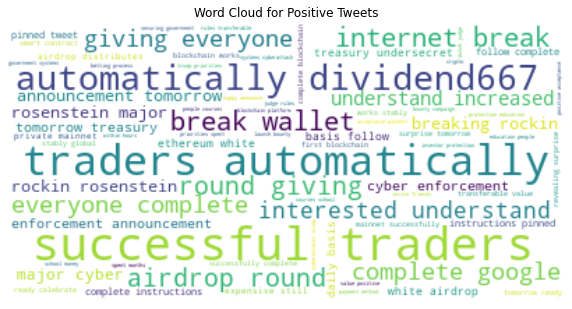

In [54]:
# visualize tokens of different sentiments with word cloud 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

#join all tokens from the list, as word cloud accepts strings as inputs 
pos_text = " ".join([" ".join(token for tokens in positive_tweets_tokens for token in tokens)])
neu_text = " ".join([" ".join(token for tokens in neutral_tweets_tokens for token in tokens)])
neg_text = " ".join([" ".join(token for tokens in negative_tweets_tokens for token in tokens)])

# Generate the image
wordcloud1 = WordCloud(stopwords=stop_words, background_color="white", max_words=100, min_word_length=5).generate(pos_text)
wordcloud2 = WordCloud(stopwords=stop_words, background_color="white", max_words=100, min_word_length=5).generate(neu_text)
wordcloud3 = WordCloud(stopwords=stop_words, background_color="white", max_words=100, min_word_length=5).generate(neg_text)

# visualize the image
fig=plt.figure(figsize=(10, 6))
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Positive Tweets')
plt.show()

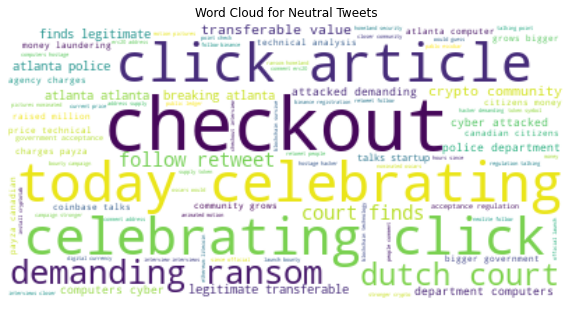

In [55]:
fig=plt.figure(figsize=(10, 6))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Neutral Tweets')
plt.show()

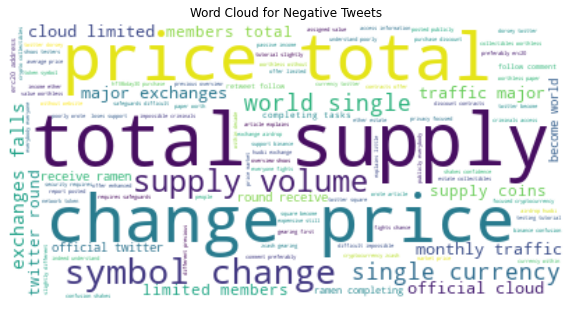

In [56]:
fig=plt.figure(figsize=(10, 6))
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Negative Tweets')
plt.show()

## Create Features 
TF-IDF (term frequency-inverse document frequency) is a statistical measure that evaluates how relevant a word is to a document in a collection of documents.

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

# we set the feature dimension to 2500
vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stop_words)
tfidf_feature = vectorizer.fit_transform(cleaned_tweets).toarray()
tfidf_feature.shape

(50859, 2500)

## Oversampling the Dataset

Due to the imbalanced feature of the current dataset, we would like to generate new samples in the classes which are under-represented. Install imblearn and use over sampling method. It can generate new samples by randomly sampling with replacement the current available samples. 

In [60]:
!pip install imblearn

     |████████████████████████████████| 189 kB 3.5 MB/s eta 0:00:01


In [61]:
# install and import imblearn module to do the oversampling
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
ros = RandomOverSampler(random_state=0)

X = tfidf_feature
y = cleaned[['sent_score']]
X_resampled, y_resampled = ros.fit_resample(X, y)

print(sorted(Counter(y_resampled).items()))
len(y_resampled[y_resampled['sent_score']==-1])

[('sent_score', 1)]


22937

## Model Selection and Tuning
Try with the following models:
1. Logistic Regression -- good performance! low complexity
2. Naive Bayes -- not a good choice
3. Decision Tree -- runtime is too long, best performance
4. Random Forest -- runtime is too long, best performance

Note that we didn't use RF for the tuning, because it takes a really long time to process. Logistic regression also has a comparable performance. But we still use an untuned RF for the classification on unseen dataset and compare its result with logistic regression.

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#split the dataset into train and test dataset 
#target is the sent_score column in cleaned
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=0)

In [69]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
predictions=clf.predict(X_test)

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[4311  236   78]
 [ 114 4364   90]
 [  96  257 4217]]
              precision    recall  f1-score   support

        -1.0       0.95      0.93      0.94      4625
         0.0       0.90      0.96      0.93      4568
         1.0       0.96      0.92      0.94      4570

    accuracy                           0.94     13763
   macro avg       0.94      0.94      0.94     13763
weighted avg       0.94      0.94      0.94     13763

0.9367143791324566


Notes:\
The overall accuracy is 0.94 which is good. The precision, recall and f1-score among 3 different categories are relatively balanced. Logistic Regression can be a good choice. 

In [70]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
predictions = gnb.fit(X_train, y_train).predict(X_test)

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[4542   42   41]
 [1455 2965  148]
 [ 921  312 3337]]
              precision    recall  f1-score   support

        -1.0       0.66      0.98      0.79      4625
         0.0       0.89      0.65      0.75      4568
         1.0       0.95      0.73      0.82      4570

    accuracy                           0.79     13763
   macro avg       0.83      0.79      0.79     13763
weighted avg       0.83      0.79      0.79     13763

0.7879096127297828


Notes:\
Naive Bayes cannot classify negative sentiment well. The precision is only 0.66. Cases of neutral and positive sentiment are misclassified into the negative category. The recall of neutral class is low, which means many of neutral texts are classified into either positive and negative cases.\
The overall accuracy is 0.79 which is worse than logistic regression. 

In [71]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
predictions = clf.fit(X_train, y_train).predict(X_test)

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[4569   43   13]
 [  93 4347  128]
 [  69  178 4323]]
              precision    recall  f1-score   support

        -1.0       0.97      0.99      0.98      4625
         0.0       0.95      0.95      0.95      4568
         1.0       0.97      0.95      0.96      4570

    accuracy                           0.96     13763
   macro avg       0.96      0.96      0.96     13763
weighted avg       0.96      0.96      0.96     13763

0.9619269054711909


Notes:\
Decision tree performs well. The overall accuracy is 0.96, and the precision, recall, f1-score is really high.\
Runtime is really long, due to the high amount of features. 

In [72]:
text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)
predictions = text_classifier.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[4564   53    8]
 [  21 4497   50]
 [  28  201 4341]]
              precision    recall  f1-score   support

        -1.0       0.99      0.99      0.99      4625
         0.0       0.95      0.98      0.97      4568
         1.0       0.99      0.95      0.97      4570

    accuracy                           0.97     13763
   macro avg       0.97      0.97      0.97     13763
weighted avg       0.97      0.97      0.97     13763

0.9737702535784349


Notes:\
The performance is outstanding. However, it takes a really long time to run the model.\
Based on the performance and runtime consideration, we choose logistic regression to do the prediction. 

### Tune the Model
Logistic regression does not really have any critical hyperparameters to tune.\
We try with different solvers here.

In [73]:
from sklearn.model_selection import RepeatedStratifiedKFold,GridSearchCV,cross_val_score
import warnings
import numpy as np
warnings.filterwarnings('ignore')

In [74]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']

# define grid search
grid = dict(solver=solvers)

average_cv=[]
for i in solvers:
    print('solver is ',i)
    clf = LogisticRegression(solver=i)
    clf.fit(X_train,y_train)
    cv_error=cross_val_score(clf, X_train, y_train, cv=10)
    average_cv.append(np.mean(cv_error))
    print('cv error is ',np.mean(cv_error))
    print('\n')


solver is  newton-cg
cv error is  0.9319139676140082


solver is  lbfgs
cv error is  0.9318231311915172


solver is  liblinear
cv error is  0.9232306518387091




In [75]:
# use liblinear solver
clf = LogisticRegression(solver='liblinear',random_state=0)
predictions=clf.fit(X_train, y_train).predict(X_test)

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[4261  261  103]
 [ 126 4336  106]
 [  96  300 4174]]
              precision    recall  f1-score   support

        -1.0       0.95      0.92      0.94      4625
         0.0       0.89      0.95      0.92      4568
         1.0       0.95      0.91      0.93      4570

    accuracy                           0.93     13763
   macro avg       0.93      0.93      0.93     13763
weighted avg       0.93      0.93      0.93     13763

0.9279226912737049


## Import another unlabeled tweet dataset for application
1. This new dataset is unlabeled, but it contains user location information. So we would like to use the trained model to categorize the sentiment of these tweets and see how the sentiment varies across different countries and regions. 
2. This is a very large dataset. We choose a subset of it.

In [76]:
#https://www.kaggle.com/kaushiksuresh147/bitcoin-tweets
tweets=pd.read_csv('Bitcoin_tweets.csv')
tweets.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False


In [77]:
# make a subset
tweets=tweets.sample(frac=0.3, replace=False, random_state=1)

In [78]:
cleaned_tweets=tweets[['user_location','user_followers','date','text','hashtags']]
cleaned_tweets=cleaned_tweets.dropna()
cleaned_tweets=cleaned_tweets.reset_index(drop=True)
cleaned_tweets.head()

,user_location,user_followers,date,text,hashtags
0,İzmir,35.0,2021-09-10 21:28:28,@BoringProtocol @PandaFraternity NEW TOKEN 🥳\...,"['Bitcoin', 'ethereum', 'doge', 'dogecoin']"
1,"San Diego, California",5659.0,2021-07-20 04:12:08,#Bitcoin dropping. \n\nPros are ready. Come to...,['Bitcoin']
2,Layyah,1656.0,2021-08-09 10:04:31,@BitcoinBob An amazing project is coming to ma...,"['xircusnft', 'nft', 'BSC', 'BinanceSmartChain..."
3,Metaverse,314.0,2021-11-11 13:25:35,watch this 👀 👇👇#bitcoin $btc #ETF #Spot https:...,"['bitcoin', 'ETF', 'Spot']"
4,World,14460.0,2021-04-20 20:24:07,"🔼🔼 ₿1 = $56,944 (20:24 UTC)\n$BTC prices conti...","['Bitcoin', 'btcusd', 'btc']"


In [79]:
#get all tweets 
unlabeled_tweets=cleaned_tweets[['text']].values.tolist()
unlabeled_tweets_tokens=[]
unlabeled_cleaned_tweets=[]

#same data cleaning procedure
for each in unlabeled_tweets:
    temp = each[0].lower()
    #remove hashtags and mentions 
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    #remove links
    temp = re.sub(r"http\S+", "", temp)
    temp = re.sub(r"www.\S+", "", temp)
    #remove punctuations
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    #filter all non-alphanumeric characters (emoticons emoji)
    temp = re.sub("[^a-z0-9]"," ", temp)
    #tokenize
    word_tokens = word_tokenize(temp)
    filtered= [w for w in word_tokens if not w in stop_words]
    filtered_join=' '.join(filtered)
    #create two different list, one for tokenized tweets, one for strings 
    unlabeled_cleaned_tweets.append(filtered_join)
    unlabeled_tweets_tokens.append(filtered)

In [80]:
# we set the feature dimension to 2500
# we have to make the feature matrix of this new dataset completely same with the dataset used to fit the model
vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stop_words)
tfidf_feature_new = vectorizer.fit_transform(unlabeled_cleaned_tweets).toarray()
tfidf_feature_new.shape

(299828, 2500)

### Predict the New Dataset Using Two Models

In [81]:
#predict the sentiment 
#use the untuned random forest to make one column
new_predictions = text_classifier.predict(tfidf_feature_new)

In [82]:
cleaned_tweets['result_RF']=new_predictions
#use the tuned logistic regression to make another column
new_predictions2 = clf.predict(tfidf_feature_new)
cleaned_tweets['result_LR']=new_predictions2
cleaned_tweets.head()

,user_location,user_followers,date,text,hashtags,result_RF,result_LR
0,İzmir,35.0,2021-09-10 21:28:28,@BoringProtocol @PandaFraternity NEW TOKEN 🥳\...,"['Bitcoin', 'ethereum', 'doge', 'dogecoin']",0.0,0.0
1,"San Diego, California",5659.0,2021-07-20 04:12:08,#Bitcoin dropping. \n\nPros are ready. Come to...,['Bitcoin'],-1.0,-1.0
2,Layyah,1656.0,2021-08-09 10:04:31,@BitcoinBob An amazing project is coming to ma...,"['xircusnft', 'nft', 'BSC', 'BinanceSmartChain...",0.0,-1.0
3,Metaverse,314.0,2021-11-11 13:25:35,watch this 👀 👇👇#bitcoin $btc #ETF #Spot https:...,"['bitcoin', 'ETF', 'Spot']",0.0,-1.0
4,World,14460.0,2021-04-20 20:24:07,"🔼🔼 ₿1 = $56,944 (20:24 UTC)\n$BTC prices conti...","['Bitcoin', 'btcusd', 'btc']",0.0,0.0


In [83]:
different_result = cleaned_tweets[cleaned_tweets['result_RF']!=cleaned_tweets['result_LR']]
different_result

,user_location,user_followers,date,text,hashtags,result_RF,result_LR
2,Layyah,1656.0,2021-08-09 10:04:31,@BitcoinBob An amazing project is coming to ma...,"['xircusnft', 'nft', 'BSC', 'BinanceSmartChain...",0.0,-1.0
3,Metaverse,314.0,2021-11-11 13:25:35,watch this 👀 👇👇#bitcoin $btc #ETF #Spot https:...,"['bitcoin', 'ETF', 'Spot']",0.0,-1.0
5,server,117.0,2021-10-18 12:40:08,Current #Bitcoin Price is 61151$ #BTC #Crypto,"['Bitcoin', 'BTC', 'Crypto']",1.0,0.0
6,sales@donamez.com,2159.0,2021-08-09 17:13:21,Bitcoin and crypto is 🚀🔥⬆️🔥. NFTs are 🔥🚀⬆️🚀. W...,"['invest', 'Bitcoin', 'Crypto', 'NFTs', 'NFTGi...",0.0,-1.0
14,Patokan jawa timur,28.0,2021-08-25 15:21:37,"@prcycoin The one of best cryptos, I am enthu...","['Airdrops', 'Bitcoin', 'crypto', 'Blockchain'...",1.0,0.0
...,...,...,...,...,...,...,...
299802,Ancient Mars,180.0,2021-07-19 22:40:42,DogeBTC &gt; Mining BTC\n\n@cz_binance @elonmu...,"['DogeBTC', 'cryptotrading', 'Cryptocurency', ...",0.0,-1.0
299804,"Earth, Milky Way",20.0,2021-06-22 16:33:51,On my way to my 1st whole #Bitcoin I am gratef...,"['Bitcoin', 'StackingSats', 'investopedia']",0.0,1.0
299811,Trading Strategies,580.0,2021-11-19 17:18:03,$BTC.X $ETH.X $XRP.X #Markets #Bitcoin #Ethere...,"['Markets', 'Bitcoin', 'Ethereum', 'technical_...",0.0,-1.0
299818,"Yonkers, NY",179.0,2021-11-25 01:23:57,Crypto Prices (USD/₿)\n\nBitcoin ➽ $57858.8354...,"['Crypto', 'Bitcoin', 'BitcoinCash', 'Polygon'...",-1.0,0.0


Among 299828 rows, there are 79182 rows have different prediction results between random forest and logistic regression. The rate is 26%. We can eliminate all rows with different results.

In [84]:
same_result = cleaned_tweets[cleaned_tweets['result_RF']==cleaned_tweets['result_LR']]
#for the user location, many entries are ineligible. We should check it.
same_result['user_location'].unique()

array(['İzmir', 'San Diego, California', 'World', ..., 'Terni, Umbria',
       'Sunny South of England', 'SEOUL/JEONJU/DAEJEON/'], dtype=object)

## How Public Opinions towards Bitcoin Vary among Different Regions

In [85]:
# use geotext to fetch city names from the messy data
! pip install geotext

     |████████████████████████████████| 2.0 MB 2.7 MB/s eta 0:00:01


In [86]:
from geotext import GeoText
#define a function to extract city 
def extract_city(x):
    a=GeoText(x).cities
    if a==[]:
        return 'unknown'
    else:
        return a[0]
    
same_result['city']=same_result['user_location'].apply(lambda x: extract_city(x))

In [87]:
same_result[same_result['city']!='unknown'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71370 entries, 1 to 299823
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_location   71370 non-null  object 
 1   user_followers  71370 non-null  float64
 2   date            71370 non-null  object 
 3   text            71370 non-null  object 
 4   hashtags        71370 non-null  object 
 5   result_RF       71370 non-null  float64
 6   result_LR       71370 non-null  float64
 7   city            71370 non-null  object 
dtypes: float64(3), object(5)
memory usage: 4.9+ MB


In [88]:
#Among the 220646 rows, there are 71370 rows have a valid city name, which is large enough for our analysis
new=same_result[same_result['city']!='unknown']
city_count=new.groupby('city').size().sort_values(ascending=False)
top_15_city=city_count[:15].to_frame().reset_index().rename(columns={'city':'City', 0:'count'})
top_30_city=city_count[:30].to_frame().reset_index().rename(columns={'city':'City', 0:'count'})
top_15_city

,City,count
0,London,6339
1,New York,5472
2,Dhaka,2175
3,Los Angeles,2145
4,Florida,1240
5,Toronto,1132
6,Seattle,1112
7,Paris,1044
8,Chicago,936
9,Washington,928


### Valid Tweets Count in Major Cities (Top 15)

<AxesSubplot:xlabel='City', ylabel='count'>

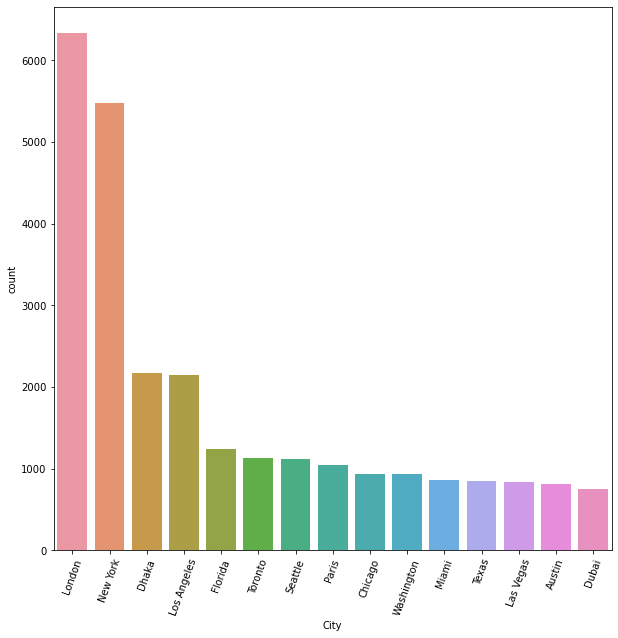

In [89]:
#visualize 
plt.figure(figsize=(10,10))
plt.xticks(rotation=70)
sns.barplot(x="City", y="count", data=top_15_city)

In [90]:
top_30_city_name=list(top_30_city['City'])

In [91]:
# see how sentiment varies
city_sentiment=new.groupby(['city','result_RF']).size().sort_values(ascending=False).to_frame().reset_index()
city_sentiment=city_sentiment.rename(columns={0:'count'})
selected_top_30=city_sentiment[city_sentiment['city'].isin(top_30_city_name)]
selected_top_30

,city,result_RF,count
0,London,0.0,4332
1,New York,0.0,3803
2,Dhaka,0.0,1505
3,Los Angeles,0.0,1499
4,London,1.0,1309
...,...,...,...
249,Boston,-1.0,44
283,New Orleans,-1.0,36
319,Ontario,-1.0,31
414,New Orleans,1.0,23


## How Sentiment Distribution Varies among Different Cities

<AxesSubplot:xlabel='city', ylabel='Count'>

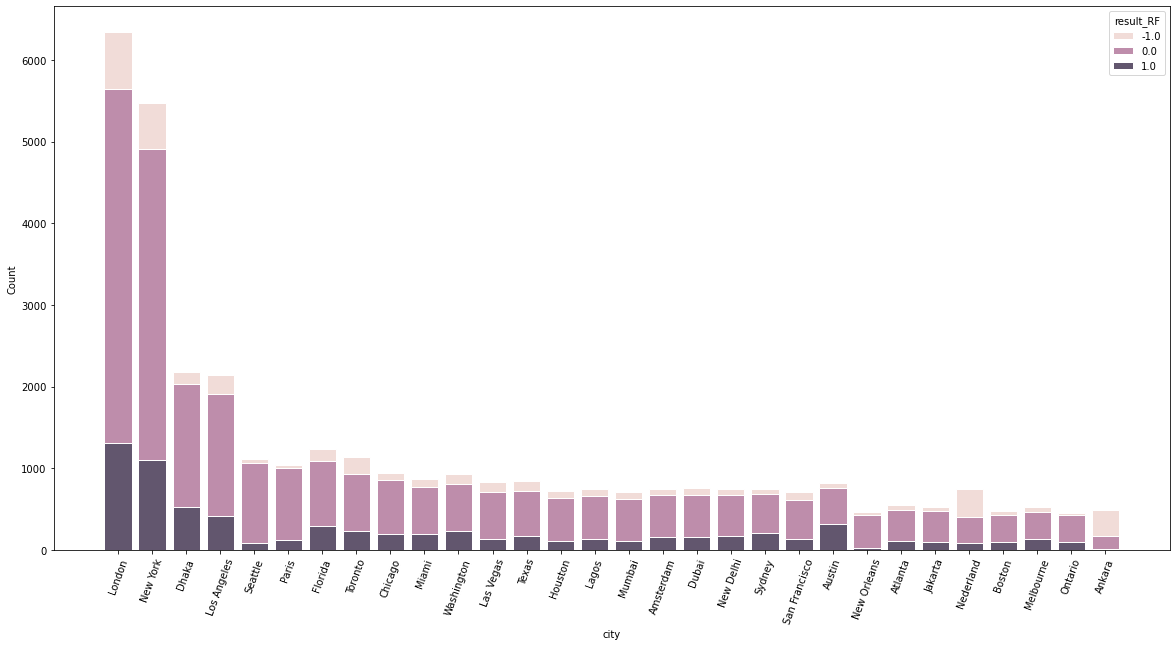

In [92]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=70)

sns.histplot(
    selected_top_30,
    x='city',
    # Use the value variable here to turn histogram counts into weighted
    # values.
    weights='count',
    hue='result_RF',
    multiple='stack',
    # Add white borders to the bars.
    edgecolor='white',
    # Shrink the bars a bit so they don't touch.
    shrink=0.8
)

In [93]:
total_sum=selected_top_30.groupby('city')['count'].agg('sum').tolist()
temp=selected_top_30[selected_top_30['result_RF']==1.0]
temp=temp.rename(columns={'count':'positive'})
temp=temp.drop(columns='result_RF')
temp['negative']=selected_top_30[selected_top_30['result_RF']==-1.0]['count'].tolist()
temp['neutral']=selected_top_30[selected_top_30['result_RF']==0.0]['count'].tolist()
temp['sum']=temp['negative']+temp['neutral']+temp['positive']
temp['pos_rate']=temp['positive']/temp['sum']
temp['neg_rate']=temp['negative']/temp['sum']
temp['opinionative_rate']=(temp['negative']+temp['positive'])/temp['sum']
temp

,city,positive,negative,neutral,sum,pos_rate,neg_rate,opinionative_rate
4,London,1309,698,4332,6339,0.206499,0.110112,0.316611
5,New York,1101,568,3803,5472,0.201206,0.103801,0.305007
18,Dhaka,524,340,1505,2369,0.221190,0.143520,0.364711
27,Los Angeles,413,320,1499,2232,0.185036,0.143369,0.328405
39,Austin,311,233,977,1521,0.204471,0.153189,0.357659
40,Florida,292,201,882,1375,0.212364,0.146182,0.358545
45,Toronto,236,157,791,1184,0.199324,0.132601,0.331926
48,Washington,233,146,695,1074,0.216946,0.135940,0.352886
53,Sydney,203,129,660,992,0.204637,0.130040,0.334677
55,Chicago,194,119,582,895,0.216760,0.132961,0.349721


In [94]:
temp.sort_values(by=['opinionative_rate']).tail()

,city,positive,negative,neutral,sum,pos_rate,neg_rate,opinionative_rate
55,Chicago,194,119,582,895,0.216760,0.132961,0.349721
48,Washington,233,146,695,1074,0.216946,0.135940,0.352886
39,Austin,311,233,977,1521,0.204471,0.153189,0.357659
40,Florida,292,201,882,1375,0.212364,0.146182,0.358545
18,Dhaka,524,340,1505,2369,0.221190,0.143520,0.364711


In [95]:
temp.sort_values(by=['neg_rate']).tail()

,city,positive,negative,neutral,sum,pos_rate,neg_rate,opinionative_rate
27,Los Angeles,413,320,1499,2232,0.185036,0.143369,0.328405
18,Dhaka,524,340,1505,2369,0.221190,0.143520,0.364711
40,Florida,292,201,882,1375,0.212364,0.146182,0.358545
39,Austin,311,233,977,1521,0.204471,0.153189,0.357659
689,Ankara,12,31,152,195,0.061538,0.158974,0.220513


In [96]:
temp.sort_values(by=['pos_rate']).tail()

,city,positive,negative,neutral,sum,pos_rate,neg_rate,opinionative_rate
40,Florida,292,201,882,1375,0.212364,0.146182,0.358545
56,Miami,190,119,576,885,0.214689,0.134463,0.349153
55,Chicago,194,119,582,895,0.216760,0.132961,0.349721
48,Washington,233,146,695,1074,0.216946,0.135940,0.352886
18,Dhaka,524,340,1505,2369,0.221190,0.143520,0.364711


### Interesting Findings

The common pattern is that most tweets are classified into the neutral category. London and New York are the top 2 cities that discuss Bitcoin most based on our findings.\
We can see that Chicago, Washington, Austin, Florida, and Dhaka are the top 5 opinionative cities towards Bitcoin.\
Los Angeles, Dhaka, Florida, Austin, and Ankara	have relatively higher negative sentiment rates.\
Florida, Miami, Chicago, Washington, and Dhaka have relatively higher positive sentiment rates.\

Additional Notes:\
It is very essential to mention that the tool, geotext, that we use for extracting city names is not powerful enough to identify all cities, especially cities not locating in the US or major Europe countries. This is a limitation of our study.

### Future Work
Due to the computation power limitation, it takes a long time to do the hyperparamater tuning for Random Forest. As the untuned model has already reached a great performance, it does not bother us on conducting the classification task. However, it is still important to tune RF if we have more time. The code is as follows:

In [ ]:
#text_classifier = RandomForestClassifier(random_state=0)

n_estimators = [int(x) for x in np.linspace(start = 40, stop = 400, num = 10)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# choose three parameters to tune with 
grid = {'n_estimators':n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split}

rf = RandomForestClassifier()
clf = GridSearchCV(rf, grid)
clf.fit(X_train, y_train)
print(sorted(clf.cv_results_))

## References
ALl coursematerials: Labs, Homeworks, Midterms, Inclass-exercises
1. https://imbalanced-learn.org/stable/over_sampling.html
2. https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/